# Pixel size Optimization
This notebook outlines how the data for the pixel size optimization was generated for the Leopard-EM manuscript.
The first step was to generate a micrograph cropped to 1kx1k.

In [1]:
import sys
import mrcfile
import numpy as np

sys.argv = ['crop_mrc.py', 'all_mgraphs/93_Sep12_18.05.02_201_1.mrc', '4']

def crop_center(image, division_factor):
    """
    Crop the center of the image based on division factor
    """
    h, w = image.shape
    new_h = h // division_factor
    new_w = w // division_factor
    
    # Calculate start indices for cropping
    start_h = h//2 - new_h//2
    start_w = w//2 - new_w//2
    
    return image[start_h:start_h + new_h, start_w:start_w + new_w]

def main():
    if len(sys.argv) != 3:
        print("Usage: script.py <input_mrc> <division_factor>")
        sys.exit(1)
    
    input_file = sys.argv[1]
    division_factor = int(sys.argv[2])
    
    # Create output filename
    output_file = input_file.replace('.mrc', f'_cropped_{division_factor}.mrc')
    
    # Read input MRC
    with mrcfile.open(input_file, permissive=True) as mrc:
        data = mrc.data.copy()
        
        # Ensure the image is 2D
        print(data.shape)
        if len(data.shape) > 2:
            print("Warning: Input has more than 2 dimensions. Using first slice.")
            data = data[0]
        
        # Crop the center
        cropped_data = crop_center(data, division_factor)
        
        # Write output MRC
        with mrcfile.new(output_file, overwrite=True) as mrc_new:
            mrc_new.set_data(cropped_data.astype(np.float32))

if __name__ == "__main__":
    main()


(1, 4092, 5760)


We than ran  match template on this micrograph to get some peaks

In [2]:
from IPython.display import Markdown, display

# Read the YAML file
with open("match_template_manager_60S.yaml") as file:
    yaml_content = file.read()

# Display as markdown code block
display(Markdown(f"```yaml\n{yaml_content}\n```"))

```yaml

computational_config:
  gpu_ids:
  - 0
  - 1
  - 2
  - 3
  num_cpus: 20
defocus_search_config:
  defocus_max: 1200.0
  defocus_min: -1200.0
  defocus_step: 200.0
  enabled: true
match_template_result:
  allow_file_overwrite: true
  correlation_average_path: results/output_correlation_average_crop_4.mrc
  correlation_variance_path: results/output_correlation_variance_crop_4.mrc
  mip_path: results/output_mip_crop_4.mrc
  orientation_phi_path: results/output_orientation_phi_crop_4.mrc
  orientation_psi_path: results/output_orientation_psi_crop_4.mrc
  orientation_theta_path: results/output_orientation_theta_crop_4.mrc
  relative_defocus_path: results/output_relative_defocus_crop_4.mrc
  scaled_mip_path: results/output_scaled_mip_crop_4.mrc
micrograph_path: all_mgraphs/93_Sep12_18.05.02_201_1_cropped_4.mrc
optics_group:
  label: micrograph_1
  amplitude_contrast_ratio: 0.07
  ctf_B_factor: 150.0
  astigmatism_angle: 50.7521820068359
  defocus_u: 4837.90869140625
  defocus_v: 5617.462402
  phase_shift: 0.0
  pixel_size: 1.059
  spherical_aberration: 2.7
  voltage: 300.0
orientation_search_config:
  psi_step: 1.5
  base_grid_method: uniform
  theta_step: 2.5
preprocessing_filters:
  bandpass_filter:
    enabled: false
    falloff: 0.05
    high_freq_cutoff: 0.5
    low_freq_cutoff: 0.0
  whitening_filter:
    enabled: true
    do_power_spectrum: true
    max_freq: 1.0
    num_freq_bins: null
template_volume_path: maps/60S_map_px1.059_bscale0.5_k3dqe.mrc
  

```

In [ ]:
from leopard_em.pydantic_models.managers import MatchTemplateManager

YAML_CONFIG_PATH = "match_template_manager_60S.yaml"
ORIENTATION_BATCH_SIZE = 8

def main():
    mt_manager = MatchTemplateManager.from_yaml(YAML_CONFIG_PATH)
    mt_manager.run_match_template(ORIENTATION_BATCH_SIZE)
    df = mt_manager.results_to_dataframe()
    df.to_csv("results/results_crop_4.csv")

# NOTE: invoking from `if __name__ == "__main__"` is necessary
# for proper multiprocessing/GPU-distribution behavior
if __name__ == "__main__":
    main()


This gave us n peaks, which is enough to proceed.
We now run optimize template to get the optimal pixel size.

In [2]:
from IPython.display import Markdown, display

# Read the YAML file
with open("optimize_template_example_config.yaml") as file:
    yaml_content = file.read()

# Display as markdown code block
display(Markdown(f"```yaml\n{yaml_content}\n```"))

```yaml
#####################################################
### OptimizeTemplateManager configuration example ###
#####################################################
# An example YAML configuration to modify.
# Call `OptimizeTemplateManager.from_yaml(path)` to load this configuration.
particle_stack:
  df_path: results/results_crop_4.csv  # Needs to be readable by pandas
  extracted_box_size: [528, 528]
  original_template_size: [512, 512]
pixel_size_coarse_search:
  enabled: true
  pixel_size_min: -0.05
  pixel_size_max: 0.05
  pixel_size_step: 0.01
pixel_size_fine_search:
  enabled: true
  pixel_size_min: -0.008
  pixel_size_max: 0.008
  pixel_size_step: 0.001
preprocessing_filters:
  whitening_filter:
    do_power_spectrum: true
    enabled: true
    max_freq: 1.0  # In terms of Nyquist frequency
    num_freq_bins: null
  bandpass_filter:
    enabled: false
    falloff: null
    high_freq_cutoff: null
    low_freq_cutoff: null
computational_config:
  gpu_ids: 0
  num_cpus: 1
simulator:
  simulator_config:
    voltage: 300.0
    apply_dose_weighting: true
    dose_start: 0.0
    dose_end: 50.0
    dose_filter_modify_signal: "rel_diff"
    upsampling: -1  
    mtf_reference: "k3_300kV_FL2r"
  pdb_filepath: "/home/data/jdickerson/2DTM_test_data/models/60S_aligned_aligned_zero.pdb"
  volume_shape: [512, 512, 512]
  b_factor_scaling: 0.5
  center_atoms: false
  remove_hydrogens: true
  additional_b_factor: 0
  pixel_spacing: 1.06

```

In [ ]:
from leopard_em.pydantic_models.managers import OptimizeTemplateManager

OPTIMIZE_YAML_PATH = "optimize_template_example_config.yaml"


def main() -> None:
    """Main function to run the optimize template program."""
    otm = OptimizeTemplateManager.from_yaml(OPTIMIZE_YAML_PATH)
    otm.run_optimize_template(output_text_path="results/optimize_template_results_crop_4.txt")


if __name__ == "__main__":
    main()


Finally, we plot the results

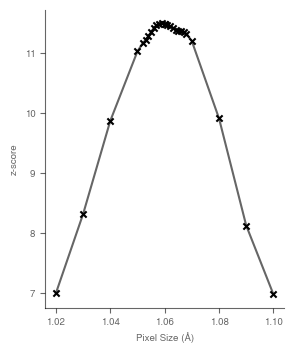

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the data from the CSV file
data = pd.read_csv('results/optimize_template_results_crop_4_all.csv')

# Sort the data by 'Pixel Size (Å)'
data = data.sort_values(by='Pixel Size (Å)')

# Create the scatter plot
fig, ax = plt.subplots(figsize=(75/25.4, 90/25.4))  # Convert mm to inches

# Plot the data with smaller markers and black color
# Filter data to only include pixel sizes between 1.02 and 1.10
filtered_data = data[(data['Pixel Size (Å)'] >= 1.02) & (data['Pixel Size (Å)'] <= 1.10)]

# Use the filtered data for plotting
data = filtered_data

ax.scatter(data['Pixel Size (Å)'], data['SNR'], marker='x', color='black', s=20)  # s is the marker size

# Add a line connecting the points
ax.plot(data['Pixel Size (Å)'], data['SNR'], color='black', alpha=0.6)

# Set font properties
plt.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 7

# Set opacity for axes and ticks
ax.spines['left'].set_alpha(0.6)
ax.spines['bottom'].set_alpha(0.6)
ax.xaxis.label.set_alpha(0.6)
ax.yaxis.label.set_alpha(0.6)
ax.tick_params(axis='x', colors=(0, 0, 0, 0.6), labelsize=7)
ax.tick_params(axis='y', colors=(0, 0, 0, 0.6), labelsize=7)

# Remove top and right axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add axis labels
ax.set_xlabel('Pixel Size (Å)', alpha=0.6, fontsize=7)
ax.set_ylabel('z-score', alpha=0.6, fontsize=7)

# Apply tight layout
plt.tight_layout()

# Save the plot to a file
plt.savefig('results/px_sizes_scatter.pdf')
plt.savefig('results/px_sizes_scatter.png', dpi=300)

# Show the plot
plt.show()